In [1]:
import math
def AMS(s, b):
    return round(math.sqrt(2*((s+b)*math.log(1+s/b)-s)),3)
def percentage(a,b): return round(abs(2*(a-b)*100/(a+b)),3)

In [2]:
from coffea.util import load
import numpy as np
import pandas as pd
import glob, os, json, argparse
years = ['2016preVFP', '2017', '2016postVFP','2018']
var_dict = {}
for year in years:
    print(f'Processing {year}')
    for subsample in ['signal','diboson','tt','others']:
        result = load(f"../results/{year}/makeDF/output_testv9_{subsample}.coffea")
        if isinstance(result,tuple):
            result = result[0]
        for varName in result:
            if varName in var_dict:
                var_dict[varName] = np.append(var_dict[varName],result[varName].value)
            else:
                var_dict[varName] = result[varName].value
df = pd.DataFrame(var_dict).drop(['is2016preVFP', 'is2016postVFP', 'is2017', 'is2018'], axis=1)

Processing 2016preVFP
Processing 2017
Processing 2016postVFP
Processing 2018


In [3]:
df = df[(df['opp_charge']==1)].drop(['opp_charge'], axis=1)

In [4]:
feature_names_2jets_GG = ['njets', 'met', 'DeltaEta_e_m', 'empt', 'DeltaPhi_em_met', 'j1pt', 'j1Eta', 'DeltaEta_j1_j2', 'j1_j2_mass', 'DeltaEta_j1_em', 'Ht_had', 'Rpt', 'j2pt', 'pt_cen_Deltapt']
feature_names_2jets_VBF = ['Zeppenfeld_DeltaEta', 'met', 'DeltaEta_e_m', 'empt', 'j1pt', 'DeltaEta_j1_j2', 'j1_j2_mass', 'Ht_had', 'Rpt', 'j2pt', 'pt_cen_Deltapt']

In [5]:
import xgboost as xgb
model_gg = xgb.XGBClassifier()
model_gg.load_model(f'./results/model_GG.json')
model_vbf = xgb.XGBClassifier()
model_vbf.load_model(f'./results/model_VBF.json')

In [6]:
df['mva_gg'] = model_gg.predict_proba(df[feature_names_2jets_GG])[:,1]
df['mva_vbf'] = model_vbf.predict_proba(df[feature_names_2jets_VBF])[:,1]

/afs/crc.nd.edu/user/k/kho2/miniconda3/envs/my-coffea-env/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [7]:
df_gg = df[(df['isVBFcat']==0)]
df_gg_m = df_gg[df_gg['mtrigger']==1]
df_gg_e = df_gg[(df_gg['etrigger']==1)&(df_gg['mtrigger']==0)]
df_vbf = df[(df['isVBFcat']==1)]
df_vbf_m = df_vbf[df_vbf['mtrigger']==1]
df_vbf_e = df_vbf[(df_vbf['etrigger']==1)&(df_vbf['mtrigger']==0)]

In [8]:
from coffea import hist
h = hist.Hist("Events", hist.Cat("dataset", "samples"), hist.Bin('mva', 'ggH BDT Discriminator', 50, 0, 1))
h.fill(dataset = 'signal (SingleMu trig)', mva = df_gg_m[(df_gg_m['label']==1)]['mva_gg'].to_numpy(), weight=df_gg_m[(df_gg_m['label']==1)]['weight'].to_numpy())
h.fill(dataset = 'background (SingleMu trig)', mva = df_gg_m[(df_gg_m['label']==0)]['mva_gg'].to_numpy(), weight=df_gg_m[(df_gg_m['label']==0)]['weight'].to_numpy())
h.fill(dataset = 'signal (SingleE trig failing SingleMu)', mva = df_gg_e[(df_gg_e['label']==1)]['mva_gg'].to_numpy(), weight=df_gg_e[(df_gg_e['label']==1)&(df_gg_e['mtrigger']==0)&(df_gg_e['etrigger']==1)]['weight'].to_numpy())
h.fill(dataset = 'background (SingleE trig failing SingleMu)', mva = df_gg_e[(df_gg_e['label']==0)]['mva_gg'].to_numpy(), weight=df_gg_e[(df_gg_e['label']==0)&(df_gg_e['mtrigger']==0)&(df_gg_e['etrigger']==1)]['weight'].to_numpy())

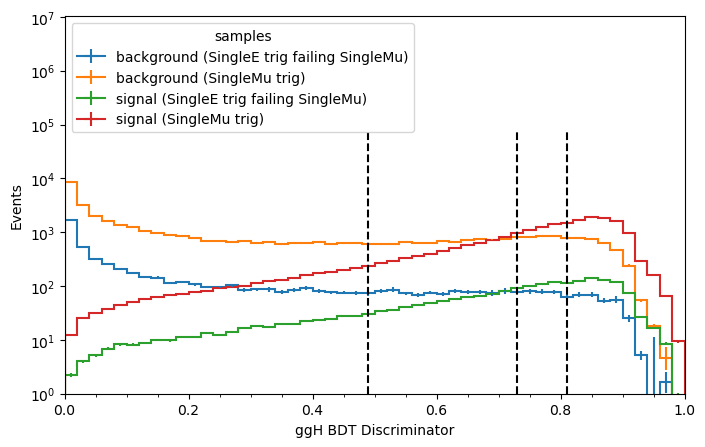

In [9]:
catlabel2 = 'ggH'
bdtcut = [0.49,0.73,0.81]
from matplotlib.pyplot import figure
import matplotlib.transforms as transforms
fig = figure(figsize=(8, 5), dpi=100)
ax = hist.plot1d(h)
trans = transforms.blended_transform_factory(ax.get_xaxis_transform(), ax.transAxes)
ax.set_yscale('log')
ax.set_ylim(1, max(h.sum("dataset").values()[()])*1e3)
ax.minorticks_on()
ax.yaxis.set_tick_params(which='minor', bottom=False)
for i,cut in enumerate(bdtcut):
    ax.axvline(x=cut, ymax=0.7, linestyle='--', color='black')
#     j = i
#     if i == 0:
#         ax.text(bdtcut[j]/2, 0.63, f'{catlabel2}cat{j}', horizontalalignment='center', size='small', transform=trans, rotation='vertical')
#     else:
#         ax.text(bdtcut[j-1]+(bdtcut[j]-bdtcut[j-1])/2, 0.63, f'{catlabel2}cat{j}', horizontalalignment='center', size='small', transform=trans, rotation='vertical')


fig.savefig(f'../plots/ARCchecks/sequence_gg_singleE.png')

In [10]:
bdtcut_ams = [0,0.49,0.73,0.81,1]
overall_ams, overall_new_ams = 0, 0
for i, j in enumerate(bdtcut_ams[:-1]):
    dump_s = 5.9*10e-3*df_gg_e[(df_gg_e['label']==1) & (df_gg_e['mva_gg']>bdtcut_ams[i]) & (df_gg_e['mva_gg']<=bdtcut_ams[i+1])].weight.sum()
    dump_b = df_gg_e[(df_gg_e['label']==0) & (df_gg_e['mva_gg']>bdtcut_ams[i]) & (df_gg_e['mva_gg']<=bdtcut_ams[i+1])].weight.sum()
    keep_s = 5.9*10e-3*df_gg_m[(df_gg_m['label']==1) & (df_gg_m['mva_gg']>bdtcut_ams[i]) & (df_gg_m['mva_gg']<=bdtcut_ams[i+1])].weight.sum()
    keep_b = df_gg_m[(df_gg_m['label']==0) & (df_gg_m['mva_gg']>bdtcut_ams[i]) & (df_gg_m['mva_gg']<=bdtcut_ams[i+1])].weight.sum()
    print(dump_s+keep_s,dump_b+keep_b,keep_s,keep_b)
    orig_ams, new_ams = AMS(keep_s, keep_b), AMS(keep_s+dump_s, keep_b+dump_b)
    overall_ams+=orig_ams**2
    overall_new_ams+=new_ams**2
    print(orig_ams, new_ams, percentage(orig_ams, new_ams))
print(math.sqrt(overall_ams), math.sqrt(overall_new_ams), percentage(math.sqrt(overall_ams), math.sqrt(overall_new_ams)))



166.35398668873475 36075.33232971427 145.15653183674257 31110.491774661143
0.822 0.875 3.123
389.5600820954184 9061.510671218468 350.7915618256211 8144.273250615214
3.86 4.064 2.574
320.8767495209671 3613.019697116299 295.5980722891416 3311.4895507399933
5.063 5.262 1.927
590.5070654510181 3632.6798742371357 549.4924527436972 3315.5643971781897
9.296 9.548 1.337
11.297117729757444 11.667676246793961 1.614


In [11]:
from coffea import hist
h = hist.Hist("Events", hist.Cat("dataset", "samples"), hist.Bin('mva', 'VBF BDT Discriminator', 50, 0, 1))
h.fill(dataset = 'signal (SingleMu trig)', mva = df_vbf_m[(df_vbf_m['label']==1)]['mva_vbf'].to_numpy(), weight=df_vbf_m[(df_vbf_m['label']==1)]['weight'].to_numpy())
h.fill(dataset = 'background (SingleMu trig)', mva = df_vbf_m[(df_vbf_m['label']==0)]['mva_vbf'].to_numpy(), weight=df_vbf_m[(df_vbf_m['label']==0)]['weight'].to_numpy())
h.fill(dataset = 'signal (SingleE trig failing SingleMu)', mva = df_vbf_e[(df_vbf_e['label']==1)]['mva_vbf'].to_numpy(), weight=df_vbf_e[(df_vbf_e['label']==1)&(df_vbf_e['mtrigger']==0)&(df_vbf_e['etrigger']==1)]['weight'].to_numpy())
h.fill(dataset = 'background (SingleE trig failing SingleMu)', mva = df_vbf_e[(df_vbf_e['label']==0)]['mva_vbf'].to_numpy(), weight=df_vbf_e[(df_vbf_e['label']==0)&(df_vbf_e['mtrigger']==0)&(df_vbf_e['etrigger']==1)]['weight'].to_numpy())

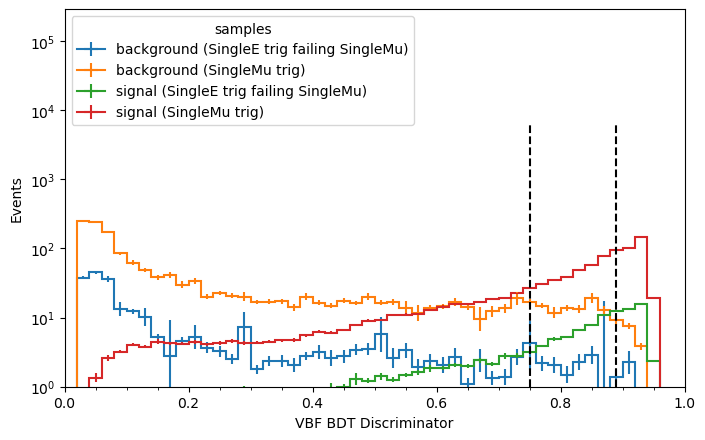

In [12]:
catlabel2 = 'VBF'
bdtcut = [0.75,0.89]
from matplotlib.pyplot import figure
import matplotlib.transforms as transforms
fig = figure(figsize=(8, 5), dpi=100)
ax = hist.plot1d(h)
trans = transforms.blended_transform_factory(ax.get_xaxis_transform(), ax.transAxes)
ax.set_yscale('log')
ax.set_ylim(1, max(h.sum("dataset").values()[()])*1e3)
ax.minorticks_on()
ax.yaxis.set_tick_params(which='minor', bottom=False)
for i,cut in enumerate(bdtcut):
    ax.axvline(x=cut, ymax=0.7, linestyle='--', color='black')
#     j = i
#     if i == 0:
#         ax.text(bdtcut[j]/2, 0.63, f'{catlabel2}cat{j}', horizontalalignment='center', size='small', transform=trans, rotation='vertical')
#     else:
#         ax.text(bdtcut[j-1]+(bdtcut[j]-bdtcut[j-1])/2, 0.63, f'{catlabel2}cat{j}', horizontalalignment='center', size='small', transform=trans, rotation='vertical')


fig.savefig(f'../plots/ARCchecks/sequence_vbf_singleE.png')

In [13]:
bdtcut_ams = [0.75,0.89,1]
overall_ams, overall_new_ams = 0, 0
for i, j in enumerate(bdtcut_ams[:-1]):
    dump_s = 5.9*10e-3*df_vbf_e[(df_vbf_e['label']==1) & (df_vbf_e['mva_vbf']>bdtcut_ams[i]) & (df_vbf_e['mva_vbf']<=bdtcut_ams[i+1])].weight.sum()
    dump_b = df_vbf_e[(df_vbf_e['label']==0) & (df_vbf_e['mva_vbf']>bdtcut_ams[i]) & (df_vbf_e['mva_vbf']<=bdtcut_ams[i+1])].weight.sum()
    keep_s = 5.9*10e-3*df_vbf_m[(df_vbf_m['label']==1) & (df_vbf_m['mva_vbf']>bdtcut_ams[i]) & (df_vbf_m['mva_vbf']<=bdtcut_ams[i+1])].weight.sum()
    keep_b = df_vbf_m[(df_vbf_m['label']==0) & (df_vbf_m['mva_vbf']>bdtcut_ams[i]) & (df_vbf_m['mva_vbf']<=bdtcut_ams[i+1])].weight.sum()
    print(dump_s+keep_s,dump_b+keep_b,keep_s,keep_b)
    orig_ams, new_ams = AMS(keep_s, keep_b), AMS(keep_s+dump_s, keep_b+dump_b)
    overall_ams+=orig_ams**2
    overall_new_ams+=new_ams**2
    print(orig_ams, new_ams, percentage(orig_ams, new_ams))
print(math.sqrt(overall_ams), math.sqrt(overall_new_ams), percentage(math.sqrt(overall_ams), math.sqrt(overall_new_ams)))



23.458154320242 113.62844742526391 20.647616102902326 99.4553909978617
2.004 2.131 3.071
20.816396055514662 18.827890635524653 18.60787224027238 15.483067723435376
4.074 4.172 1.188
4.540208365262546 4.684735318030251 1.567


In [ ]:
4.540208365262546**2+11.297117729757444**2

In [20]:
df_dump = df[(df['isVBFcat']==1) & (df['mva_vbf']<0.75)]
df_gg = df[(df['isVBFcat']==0)]

In [21]:
catlabel2 = 'ggH'
bdtcut = [0.49,0.73,0.81]

In [72]:
from coffea import hist
h = hist.Hist("Events", hist.Cat("dataset", "samples"), hist.Bin('mva', 'ggH BDT Discriminator', 50, 0, 1))
h.fill(dataset = 'signal (ggH category)', mva = df_gg[df_gg['label']==1]['mva_gg'].to_numpy(), weight=df_gg[df_gg['label']==1]['weight'].to_numpy())
h.fill(dataset = 'background (ggH category)', mva = df_gg[df_gg['label']==0]['mva_gg'].to_numpy(), weight=df_gg[df_gg['label']==0]['weight'].to_numpy())
h.fill(dataset = 'signal (discarded from the VBF BDT)', mva = df_dump[df_dump['label']==1]['mva_gg'].to_numpy(), weight=df_dump[df_dump['label']==1]['weight'].to_numpy())
h.fill(dataset = 'background (discarded from the VBF BDT)', mva = df_dump[df_dump['label']==0]['mva_gg'].to_numpy(), weight=df_dump[df_dump['label']==0]['weight'].to_numpy())

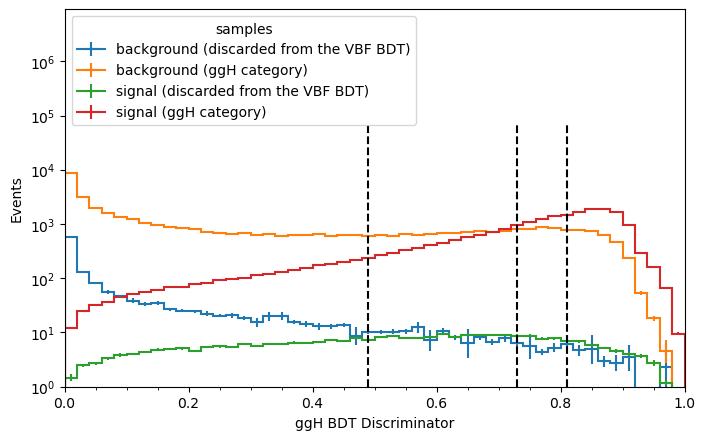

In [73]:
from matplotlib.pyplot import figure
import matplotlib.transforms as transforms
trans = transforms.blended_transform_factory(ax.get_xaxis_transform(), ax.transAxes)
fig = figure(figsize=(8, 5), dpi=100)
ax = hist.plot1d(h)
ax.set_yscale('log')
ax.set_ylim(1, max(h.sum("dataset").values()[()])*1e3)
ax.minorticks_on()
ax.yaxis.set_tick_params(which='minor', bottom=False)
for i,cut in enumerate(bdtcut):
    ax.axvline(x=cut, ymax=0.7, linestyle='--', color='black')
#     j = i
#     if i == 0:
#         ax.text(bdtcut[j]/2, 0.63, f'{catlabel2}cat{j}', horizontalalignment='center', size='small', transform=trans, rotation='vertical')
#     else:
#         ax.text(bdtcut[j-1]+(bdtcut[j]-bdtcut[j-1])/2, 0.63, f'{catlabel2}cat{j}', horizontalalignment='center', size='small', transform=trans, rotation='vertical')


fig.savefig(f'../plots/ARCchecks/sequence_gg_vbf.png')

In [ ]:
bdtcut_ams = [0,0.49,0.73,0.81,1]
overall_ams, overall_new_ams = 0, 0
for i, j in enumerate(bdtcut_ams[:-1]):
    dump_s = 5.9*10e-3*df_dump[(df_dump['label']==1) & (df_dump['mva_gg']>bdtcut_ams[i]) & (df_dump['mva_gg']<=bdtcut_ams[i+1])].weight.sum()
    dump_b = df_dump[(df_dump['label']==0) & (df_dump['mva_gg']>bdtcut_ams[i]) & (df_dump['mva_gg']<=bdtcut_ams[i+1])].weight.sum()
    keep_s = 5.9*10e-3*df_gg[(df_gg['label']==1) & (df_gg['mva_gg']>bdtcut_ams[i]) & (df_gg['mva_gg']<=bdtcut_ams[i+1])].weight.sum()
    keep_b = df_gg[(df_gg['label']==0) & (df_gg['mva_gg']>bdtcut_ams[i]) & (df_gg['mva_gg']<=bdtcut_ams[i+1])].weight.sum()
    print(dump_s,dump_b,keep_s,keep_b)
    orig_ams, new_ams = AMS(keep_s, keep_b), AMS(keep_s+dump_s, keep_b+dump_b)
    overall_ams+=orig_ams**2
    overall_new_ams+=new_ams**2
    print(orig_ams, new_ams, percentage(orig_ams, new_ams))
print(math.sqrt(overall_ams), math.sqrt(overall_new_ams), percentage(math.sqrt(overall_ams), math.sqrt(overall_new_ams)))


In [74]:
import math
def AMS(s, b):
    return round(math.sqrt(2*((s+b)*math.log(1+s/b)-s)),3)
def percentage(a,b): return round(abs((a-b)*100/(a+b)),3)

In [78]:
bdtcut_ams = [0,0.49,0.73,0.81,1]
overall_ams, overall_new_ams = 0, 0
for i, j in enumerate(bdtcut_ams[:-1]):
    dump_s = 5.9*10e-3*df_dump[(df_dump['label']==1) & (df_dump['mva_gg']>bdtcut_ams[i]) & (df_dump['mva_gg']<=bdtcut_ams[i+1])].weight.sum()
    dump_b = df_dump[(df_dump['label']==0) & (df_dump['mva_gg']>bdtcut_ams[i]) & (df_dump['mva_gg']<=bdtcut_ams[i+1])].weight.sum()
    keep_s = 5.9*10e-3*df_gg[(df_gg['label']==1) & (df_gg['mva_gg']>bdtcut_ams[i]) & (df_gg['mva_gg']<=bdtcut_ams[i+1])].weight.sum()
    keep_b = df_gg[(df_gg['label']==0) & (df_gg['mva_gg']>bdtcut_ams[i]) & (df_gg['mva_gg']<=bdtcut_ams[i+1])].weight.sum()
    print(dump_s,dump_b,keep_s,keep_b)
    orig_ams, new_ams = AMS(keep_s, keep_b), AMS(keep_s+dump_s, keep_b+dump_b)
    overall_ams+=orig_ams**2
    overall_new_ams+=new_ams**2
    print(orig_ams, new_ams, percentage(orig_ams, new_ams))
print(math.sqrt(overall_ams), math.sqrt(overall_new_ams), percentage(math.sqrt(overall_ams), math.sqrt(overall_new_ams)))


7.536589887035017 1282.1829318354319 145.15653183674257 31110.491774661143
0.822 0.848 1.557
6.0284677831852065 107.97661018637514 350.7915618256211 8144.273250615214
3.86 3.9 0.515
1.9103121416484459 20.452943984912594 295.5980722891416 3311.4895507399933
5.063 5.08 0.168
2.214707322405602 26.285409104008664 549.4924527436972 3315.5643971781897
9.296 9.298 0.011
11.297117729757444 11.322027556935199 0.11
